# Computational Inference via NumPyro

We want try out what we learned about computational inference and conduct the inferences we did in the previous notebook now with the use of sampling methods. We will be using the NumPyro library, to which we will do a short introduction before digging into the inference part. 

## 1. Model specification in NumPyro

As before we want to estimate the probability of a coin landing heads based on a number of observed flips. Assuming a Beta-distributed prior with parameters $\alpha=\beta=10$, the model has the form 

$$
    \theta \sim \mathrm{Beta}(10, 10) \\
    y_i \sim \mathrm{Bernoulli}(\theta) \quad i = 1, \dots, N
$$

### Numpy

Let's start by building a probabilistic model as a Python function just using NumPy.

In [1]:
import numpy as np

rng = np.random.default_rng(seed=42)

In [2]:
rng.beta(10, 10)

0.4661241386616667

In [3]:
def model(n=1):
    theta = rng.beta(10, 10)  # prior
    y = rng.binomial(1, theta, size=n)  # likelihood
    return theta, y

In [4]:
model(20)

(0.32194090877996817,
 array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]))

Hopefully there is nothing here that is too complicated / confusing. We simply sample theta, then n samples of y given that theta and return them.

### Numpyro

The corresponding model in NumPyro will look very similar, but instead of using distributions from numpy.random we use numpyro.sample statements and pass the corresponding distribution. The reason for this will become clear in a moment

In [5]:
import numpyro
import numpyro.distributions as dist

# tell numpyro to use multiple cores
numpyro.set_host_device_count(4)

In [6]:
def model(n=1):
    theta = numpyro.sample("theta", dist.Beta(10, 10))  # prior
    y = numpyro.sample("y", dist.Bernoulli(theta).expand((n,)))  # likelihood
    return theta, y

One final change is that NumPyro, like JAX, does not maintain global random state, so we need to manually seed the model. You can read more about the reasons for this here.

In [7]:
from jax import random

rng_key = random.PRNGKey(42)

with numpyro.handlers.seed(rng_seed=rng_key):
    theta, y = model(n=20)

theta, y

(DeviceArray(0.60867184, dtype=float32),
 DeviceArray([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1], dtype=int32))

In [8]:
rng_key

DeviceArray([ 0, 42], dtype=uint32)

### Improving the model

We can make a few improvements to the model.

- We will allow the user to pass in y values for the model to condition on. This ability to condition on observed data is usually crucial in order to make inferences about the latent variables (theta in this case).
- We will replace .expand with a numpyro.plate context manager. This NumPyro primitive is another way of specifying batch dimensions inspired by plate notation and makes for more readble code + additional useful output in the model trace.
- Finally we won't bother with return values, because as we can see above all of the values are captured in the model trace. Generally we only use return values in NumPyro models for debugging purposes.

In [9]:
def model(y=None):

    n = y.shape[0] if y is not None else 20

    # prior
    theta = numpyro.sample("theta", dist.Beta(10, 10))

    # likelihood
    with numpyro.plate("n", n):
        numpyro.sample("y", dist.Bernoulli(theta), obs=y)

Numpyro lets us create neat visualizations of our probabilistic  model.

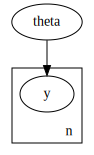

In [10]:
numpyro.render_model(model)

### Sampling from the prior
NumPyro provides a convenient interface for drawing multiple samples from a model.

In [11]:
from numpyro.infer import Predictive

In [12]:
N_SAMPLES = 4_000

In [13]:
prior = Predictive(model, num_samples=N_SAMPLES)

rng_key, subkey = random.split(rng_key)
prior_samples = prior(subkey)

prior_samples["theta"].shape, prior_samples["y"].shape

((4000,), (4000, 20))

In [14]:
prior_samples

{'theta': DeviceArray([0.3973194 , 0.5893742 , 0.38195637, ..., 0.39703476,
              0.4182834 , 0.6078557 ], dtype=float32),
 'y': DeviceArray([[0, 0, 0, ..., 1, 1, 1],
              [1, 0, 1, ..., 0, 0, 1],
              [1, 1, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 1, ..., 1, 1, 0],
              [1, 1, 1, ..., 0, 0, 0],
              [1, 1, 1, ..., 1, 1, 1]], dtype=int32)}

## 2. Bayesian inference via NumPyro

Once we've built the model inference is pretty straight-forward. Let's fit the model to the data of our lazy 3-coin toss trial. 

In [15]:
y = np.array([1, 1, 1])

In [16]:
from numpyro.infer import MCMC, NUTS

In [17]:
mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=int(N_SAMPLES / 4), num_chains=4)

rng_key, subkey = random.split(rng_key)
mcmc.run(subkey, y=y)

mcmc.print_summary()

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.56      0.10      0.56      0.40      0.73   1326.59      1.00

Number of divergences: 0


In [18]:
posterior_samples = mcmc.get_samples()

In [19]:
posterior_samples["theta"].shape

(4000,)

In [20]:
prior_samples["theta"]

DeviceArray([0.3973194 , 0.5893742 , 0.38195637, ..., 0.39703476,
             0.4182834 , 0.6078557 ], dtype=float32)

In [28]:
posterior_samples["theta"]

DeviceArray([0.55055547, 0.55055547, 0.6636222 , ..., 0.54527426,
             0.5187524 , 0.5187524 ], dtype=float32)

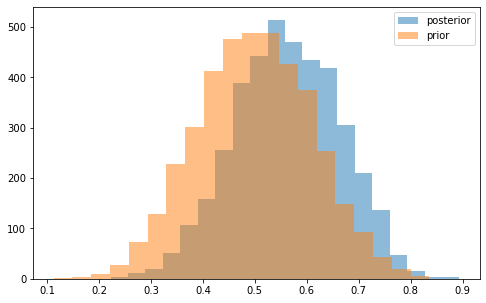

In [29]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(8, 5))
ax.hist(np.array(posterior_samples["theta"]), alpha=0.5, bins=20, label="posterior")
ax.hist(np.array(prior_samples["theta"]), alpha=0.5, bins=20, label="prior")
plt.legend(loc="best")
plt.show()

### Posterior Statistics

#### A. Expecation value

**Exercise:** Compute the Monte Carlo estimate of the expectation of $\theta$ under the posterior. For posterior samples $\theta_i$, $i=1, ..., N$, this estimate is defined by

$$\mathbb{E}\left[\theta \vert y\right] \approx \frac{1}{N}\sum_{i=1}^N \theta_i.$$

In [23]:
mean = posterior_samples["theta"].mean()
print(mean)

0.5619689


#### B. Event Probabilities

Compute the Monte Carlo estimate for the probability of $\theta \in [\theta_1, \theta_2]$ under the posterior. For posterior samples $\theta_i$, $i=1, ..., N$, this estimate is defined by,

$$ \int_{\theta_1}^{\theta_2} p(\theta \vert y) \mathrm{d} \theta \approx \frac{1}{N}\sum_{i=1}^N \chi(\theta_i \in [\theta_1, \theta_2]) $$

**Exercice:** What's the estimated probability of $\theta$ is fair within a tolerance of 0.01? 


In [24]:
posterior_samples["theta"] > 0

DeviceArray([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [25]:
proba_fair = (
    (posterior_samples["theta"] >= 0.49) & (posterior_samples["theta"] <= 0.51)
).mean()
print(proba_fair)

0.0635


#### C. Quantiles

For a given probability $P \in [0,1]$ the associated posterior quantile can be approximated via posterior samples $\theta_i$, $i=1, ..., N$ by

$$ \arg\max_x \left\{ \int_0^{x} \ p(\theta \vert y) d\theta \le P \right\} \approx \arg\max_x \left\{ \frac{1}{N}\sum_{i=1}^N \chi(\theta_i \in [0, x]) \le P \right\} $$

**Exercise:** What's the 5-th and 95-th percentile estimate?

In [26]:
perc_5 = np.quantile(posterior_samples["theta"], 0.05)
perc_95 = np.quantile(posterior_samples["theta"], 0.95)

In [27]:
print(perc_5)
print(perc_95)

0.39281658679246906
0.7268827944993973
